# Traffic Sign Recognition


In [1]:
# Unzip the uploaded data in google drive
# ! unzip "/content/drive/My Drive/Traffic Sign Recognition/traffic sign recognition.zip" -d "/content/drive/My Drive/Traffic Sign Recognition"

## Get our workspace ready

In [2]:
# # Import tensorflow into colab
# try:
#   %tensorflow_version 2.x
# except Exception:
#   pass

In [2]:
# importing necessary tools
import tensorflow as tf
print("TF version: ", tf.__version__)

# Check for GPU availability
# print("GPU", "Available (yes)" if tf.config.list_physical_devices("GPU") else "Not available")

TF version:  2.0.0


## Getting our data ready (turning into tensors)

In [4]:
import pandas as pd
train_df = pd.read_csv('./Data/Train.csv')
train_df.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000
mean,50.835880,50.328930,5.999515,5.962381,45.197302,44.728379,15.788390
std,24.306933,23.115423,1.475493,1.385440,23.060157,21.971145,12.013238
min,25.000000,25.000000,0.000000,5.000000,20.000000,20.000000,0.000000
25%,35.000000,35.000000,5.000000,5.000000,29.000000,30.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,58.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,243.000000,225.000000,20.000000,20.000000,223.000000,205.000000,42.000000


In [5]:
train_df = train_df.drop(['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2'], axis = 1)
train_df.head()

,ClassId,Path
0,20,Train/20/00020_00000_00000.png
1,20,Train/20/00020_00000_00001.png
2,20,Train/20/00020_00000_00002.png
3,20,Train/20/00020_00000_00003.png
4,20,Train/20/00020_00000_00004.png


600.0

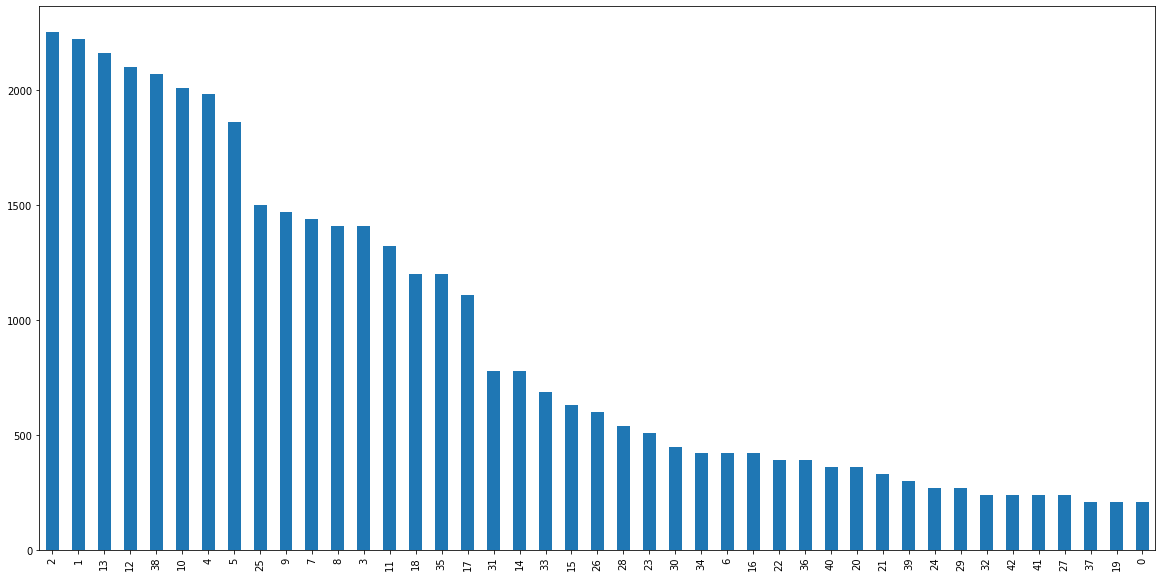

In [6]:
train_df['ClassId'].value_counts().plot.bar(figsize=(20, 10))
train_df['ClassId'].value_counts().median()

### Getting images and their labels

In [7]:
# Create pathnames from image Id's
filenames = ['D:/Machine Learning/Traffic Sign Recognition/Data/' + fname for fname in train_df['Path']]
filenames[:10]

['D:/Machine Learning/Traffic Sign Recognition/Data/Train/20/00020_00000_00000.png',
 'D:/Machine Learning/Traffic Sign Recognition/Data/Train/20/00020_00000_00001.png',
 'D:/Machine Learning/Traffic Sign Recognition/Data/Train/20/00020_00000_00002.png',
 'D:/Machine Learning/Traffic Sign Recognition/Data/Train/20/00020_00000_00003.png',
 'D:/Machine Learning/Traffic Sign Recognition/Data/Train/20/00020_00000_00004.png',
 'D:/Machine Learning/Traffic Sign Recognition/Data/Train/20/00020_00000_00005.png',
 'D:/Machine Learning/Traffic Sign Recognition/Data/Train/20/00020_00000_00006.png',
 'D:/Machine Learning/Traffic Sign Recognition/Data/Train/20/00020_00000_00007.png',
 'D:/Machine Learning/Traffic Sign Recognition/Data/Train/20/00020_00000_00008.png',
 'D:/Machine Learning/Traffic Sign Recognition/Data/Train/20/00020_00000_00009.png']

In [8]:
import numpy as np
labels = train_df['ClassId'].to_numpy()
labels

array([20, 20, 20, ..., 42, 42, 42], dtype=int64)

In [9]:
len(labels)

39209

In [10]:
unique_signs = np.unique(labels)
len(unique_signs)

43

In [11]:
# Converting the labels into one hot encoding
labels = tf.keras.utils.to_categorical(labels, 43)
labels[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [12]:
len(labels)

39209

### Creating Validation set


In [13]:
# Create X & y variables
X = filenames
y = labels

# Splitting our data into train and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)
len(X_train), len(y_train), len(X_val), len(y_val)

(31367, 31367, 7842, 7842)

### Processing image and turning into Tensors

In [14]:
IMG_SIZE = 32

def process_image(image_path):
    """
    Takes an image file path and turns the image into a Tensor.
    """
    # Read in an image file
    image = tf.io.read_file(image_path)
    # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
    image = tf.image.decode_png(image, channels=3)
    # Convert the colour channel values from 0-255 to 0-1 values
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize the image to our desired value (32, 32)
    image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

    return image

### Turning data into batches

In [15]:
# Create a simple function to return tuple

def get_image_label (image_path, label):
    """
    Takes an image file path name and the assosciated label,
    processes the image and reutrns a typle of (image, label).
    """
    image = process_image(image_path)
    return image, label

In [16]:
# Define batch size
BATCH_SIZE = 64

# Create a function to turn data into batches
def create_data_batches (X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    """
    Creates batches of data out of image (X) and label (y) pairs.
    Shuffles the data if it's training data but doesn't shuffle if it's validation data.
    Also accepts test data as input (no labels).
    """
    # If the data is a test dataset, we probably don't have have labels
    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        # If the data is a valid dataset, we don't need to shuffle it
    elif valid_data:
        print("Creating validation dataset batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        # Create (image, label) tuples (this also turns the iamge path into a preprocessed image)
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    else:
        print("Creating training dataset batches...")
        # Turn filepaths and labels into Tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
        data = data.shuffle(buffer_size=len(X))
        # Create (image, label) tuples (this also turns the iamge path into a preprocessed image) and turning into batches
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

In [17]:
# Creating training and validation batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training dataset batches...
Creating validation dataset batches...


In [18]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 43), dtype=tf.float32, name=None)),
 (TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 43), dtype=tf.float32, name=None)))

### Visualizing Data Batches


In [19]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images (images, labels):
    """
    Displays a plot of 25 images and their labels from a data batch.
    """
    plt.figure(figsize=(10,10))
    for i in range(25):
        ax = plt.subplot(5, 5, i+1)
        plt.imshow(images[i])
        plt.title(unique_signs[labels[i].argmax()])
        plt.axis("off")

In [20]:
# # Visualizing traing batch
# train_images, train_labels = next(train_data.as_numpy_iterator())
# show_25_images(train_images, train_labels)

In [21]:
# # Visualizing validation data
# val_images, val_labels = next(val_data.as_numpy_iterator())
# show_25_images(val_images, val_labels)

## Building the model

In [22]:
# Setup input shape to the model
INPUT_SHAPE = [IMG_SIZE, IMG_SIZE, 3]

# SEtup the output shape
OUTPUT_SHAPE = len(unique_signs)

In [23]:
# import necessary libraries for creating model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPool2D

# Creating CNN Model
def traffic_sign_net(input_shape):
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(43, activation='softmax'))

    return model

In [24]:
# Create a function that creates model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE):
    # Setup the model layers
    model = traffic_sign_net(input_shape=input_shape)

    # Compile the model
    print("Compiling the model")
    model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ["accuracy"]
    )

    return model

In [25]:
model = create_model()
model.summary()

Compiling the model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 

## Creating callbacks

###Creating Tensorboard callback


In [7]:
# LoadTensorboard notebook extension

%load_ext tensorboard

In [27]:
import datetime
import os

# Function to build a TensorBoard callback
def create_tensorboard_callback():
    logdir = os.path.join("D:\Machine Learning\Traffic Sign Recognition\logs",
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
                        )
    # Make it so the logs get tracked whenever we run an experiment
    return tf.keras.callbacks.TensorBoard(logdir)

### Creating Early Stopping callback

In [28]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

## Training our model

In [29]:
NUM_EPOCHS = 30

In [30]:
# Build a fn to train and return a trained model
def train_model():
    """
    Trains a given model and returns the trained version.
    """
    # Create a model
    model = create_model()
    # Create new TensorBoard session everytime we train a model
    tensorboard = create_tensorboard_callback()
    # Fit the model to the data passing it the callbacks we created
    model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
    return model

In [31]:
# Fit the model to data
model = train_model()

Compiling the model
Epoch 1/30
491/491 [==============================] - 559s 1s/step - loss: 1.4984 - accuracy: 0.5792 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/30
491/491 [==============================] - 124s 253ms/step - loss: 0.2690 - accuracy: 0.9186 - val_loss: 0.0588 - val_accuracy: 0.9833
Epoch 3/30
491/491 [==============================] - 128s 260ms/step - loss: 0.1526 - accuracy: 0.9543 - val_loss: 0.0406 - val_accuracy: 0.9901
Epoch 4/30
491/491 [==============================] - 128s 260ms/step - loss: 0.1095 - accuracy: 0.9674 - val_loss: 0.0373 - val_accuracy: 0.9880
Epoch 5/30
491/491 [==============================] - 128s 262ms/step - loss: 0.0915 - accuracy: 0.9721 - val_loss: 0.0253 - val_accuracy: 0.9934
Epoch 6/30
491/491 [==============================] - 128s 260ms/step - loss: 0.0716 - accuracy: 0.9786 - val_loss: 0.0211 - val_accuracy: 0.9954
Epoch 7/30
491/491 [==============================] - 127s 259ms/step - loss: 0.0713 - accuracy: 0.

In [ ]:
%tensorboard --logdir D:/Machine\ Learning/Traffic\ Sign\ Recognition/logs

## Saving and loading the model

In [38]:
# Function for saving the model
def save_model(model, suffix=None):
    """
    Saves a given model in a models directory and appends a suffix (string).
    """
    # Create a model directory pathname with current time
    modeldir = os.path.join("D:\Machine Learning\Traffic Sign Recognition\models",
                            datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    if suffix == None:
        model_path = modeldir + ".h5"
    else:
        model_path = modeldir + "-" + suffix + ".h5" # save format of model
    print(f"Saving model to: {model_path}...")
    model.save(model_path)
    return model_path

In [4]:
# Create a function to load a trained model
def load_model(model_path):
    """
    Loads a saved model from a specified path.
    """
    print(f"Loading model from: {model_path}")
    model =tf.keras.models.load_model(model_path)
    return model

In [39]:
save_model(model)

Saving model to: D:\Machine Learning\Traffic Sign Recognition\models\20200415-215022.h5...


'D:\\Machine Learning\\Traffic Sign Recognition\\models\\20200415-215022.h5'

In [5]:
model = load_model('D:\\Machine Learning\\Traffic Sign Recognition\\models\\20200415-215022.h5')

Loading model from: D:\Machine Learning\Traffic Sign Recognition\models\20200415-215022.h5


## Creating test dataset batches

In [46]:
test_df = pd.read_csv('./Data/test.csv')
test_df = test_df.drop(['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2'], axis=1)
test_df.head()

,ClassId,Path
0,16,Test/00000.png
1,1,Test/00001.png
2,38,Test/00002.png
3,33,Test/00003.png
4,11,Test/00004.png


In [48]:
test_img_paths = ['D:/Machine Learning/Traffic Sign Recognition/Data/' + path for path in test_df['Path']]
test_img_paths[:10]

['D:/Machine Learning/Traffic Sign Recognition/Data/Test/00000.png',
 'D:/Machine Learning/Traffic Sign Recognition/Data/Test/00001.png',
 'D:/Machine Learning/Traffic Sign Recognition/Data/Test/00002.png',
 'D:/Machine Learning/Traffic Sign Recognition/Data/Test/00003.png',
 'D:/Machine Learning/Traffic Sign Recognition/Data/Test/00004.png',
 'D:/Machine Learning/Traffic Sign Recognition/Data/Test/00005.png',
 'D:/Machine Learning/Traffic Sign Recognition/Data/Test/00006.png',
 'D:/Machine Learning/Traffic Sign Recognition/Data/Test/00007.png',
 'D:/Machine Learning/Traffic Sign Recognition/Data/Test/00008.png',
 'D:/Machine Learning/Traffic Sign Recognition/Data/Test/00009.png']

In [53]:
X_test = create_data_batches(test_img_paths, test_data=True)
y_test = list(test_df['ClassId'])
y_test[:10]

Creating test data batches...


[16, 1, 38, 33, 11, 38, 18, 12, 25, 35]

## Making and Evaluating predictions using a trained model on test data

In [68]:
predictions = model.predict(X_test, verbose=1)

198/198 [==============================] - 19s 97ms/step


In [69]:
predictions[:2]

array([[1.7278415e-19, 6.8732826e-17, 4.4170265e-21, 1.3421904e-17,
        5.3345865e-19, 3.3354544e-15, 6.3675620e-20, 1.5916060e-17,
        5.5355142e-17, 2.9443739e-09, 7.7476118e-18, 3.4468212e-17,
        5.8704669e-14, 4.8020187e-19, 1.0878617e-21, 2.1036480e-12,
        1.0000000e+00, 3.9577751e-24, 4.2025268e-19, 1.0486517e-21,
        1.5775754e-18, 3.3627058e-22, 1.6319566e-24, 2.9216755e-18,
        1.9665689e-19, 4.0455018e-23, 6.1228364e-18, 5.0811746e-21,
        1.1812345e-17, 3.7126360e-20, 6.5109463e-24, 8.7859260e-26,
        1.8590894e-11, 3.7875677e-19, 1.9326858e-19, 1.9152013e-14,
        5.7124195e-20, 1.4250071e-20, 9.5570337e-17, 1.9700594e-20,
        1.9538742e-13, 4.9216442e-16, 1.6796406e-18],
       [1.5331840e-11, 9.9999928e-01, 3.5619523e-15, 3.1865575e-25,
        1.6445321e-13, 1.0567962e-11, 7.4464378e-07, 1.7748678e-15,
        9.3357783e-25, 1.6618541e-30, 1.3025229e-25, 1.0955031e-20,
        1.3789786e-20, 3.0786530e-22, 1.2721566e-24, 1.0177851

In [65]:
# Function to convert probabilities to labels
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_signs[np.argmax(prediction_probabilities)]

In [70]:
# Turning probabilities to labels
pred_labels = []
for i in predictions:
    pred_labels.append(get_pred_label(i))
    
pred_labels[:10]

[16, 1, 38, 33, 11, 38, 18, 12, 25, 35]

In [71]:
# Getting the accuracy of the model on test data
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred_labels)
acc

0.9699129057798892